In [4]:
library(redist)
library(sf)
library(sp)
library(spdep)
library(igraph)
library(ggplot2)
library(dplyr)
library(geojsonio)
library(magrittr)


Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1

Loading required package: spData


Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union



Attaching package: 'dplyr'


The following objects are masked from 'package:igraph':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'geojsonio'


The following object is masked from 'package:base':

    pretty




In [6]:
data("algdat.p10")
data("algdat.p20")
data("algdat.pfull")


In [7]:
names(algdat.p10)
names(algdat.p20)
names(algdat.pfull)

[1] "adjlist"           "cdmat"             "precinct.data"    
[4] "segregation.index" "distancemat"

[1] "adjlist"           "cdmat"             "precinct.data"    
[4] "segregation.index" "distancemat"

[1] "adjlist"           "cdmat"             "precinct.data"    
[4] "segregation.index" "distancemat"

In [9]:
str(fl250)

Classes 'sf' and 'data.frame':	250 obs. of  12 variables:
 $ geoid10 : num  NA NA NA NA NA NA NA NA NA NA ...
 $ pop     : int  2106 859 4364 714 2361 307 3994 543 455 200 ...
 $ vap     : int  1555 656 3635 559 2020 220 3170 417 419 145 ...
 $ obama   : num  645 365 936 101 560 84 933 59 63 32 ...
 $ mccain  : num  161 33 1317 18 718 ...
 $ TotPop  : int  2106 859 4364 714 2361 307 3994 543 455 200 ...
 $ BlackPop: int  1358 646 90 371 75 230 909 245 15 10 ...
 $ HispPop : int  109 48 256 175 114 28 225 149 22 90 ...
 $ VAP_1   : int  1555 656 3635 559 2020 220 3170 417 419 145 ...
 $ BlackVAP: int  954 492 76 289 59 166 639 198 14 10 ...
 $ HispVAP : int  63 34 184 131 83 12 155 85 17 53 ...
 $ geometry:sfc_POLYGON of length 250; first list element: List of 1
  ..$ : num [1:24, 1:2] -80.7 -80.7 -80.7 -80.7 -80.7 ...
  ..- attr(*, "class")= chr [1:3] "XY" "POLYGON" "sfg"
 - attr(*, "sf_column")= chr "geometry"
 - attr(*, "agr")= Factor w/ 3 levels "constant","aggregate",..: NA NA NA N

ERROR: Error in head(fl250): object 'fl250' not found


In [2]:
fl250.dtypes

ERROR: Error in eval(expr, envir, enclos): object 'fl250.dtypes' not found


Agency-Based Redistricting

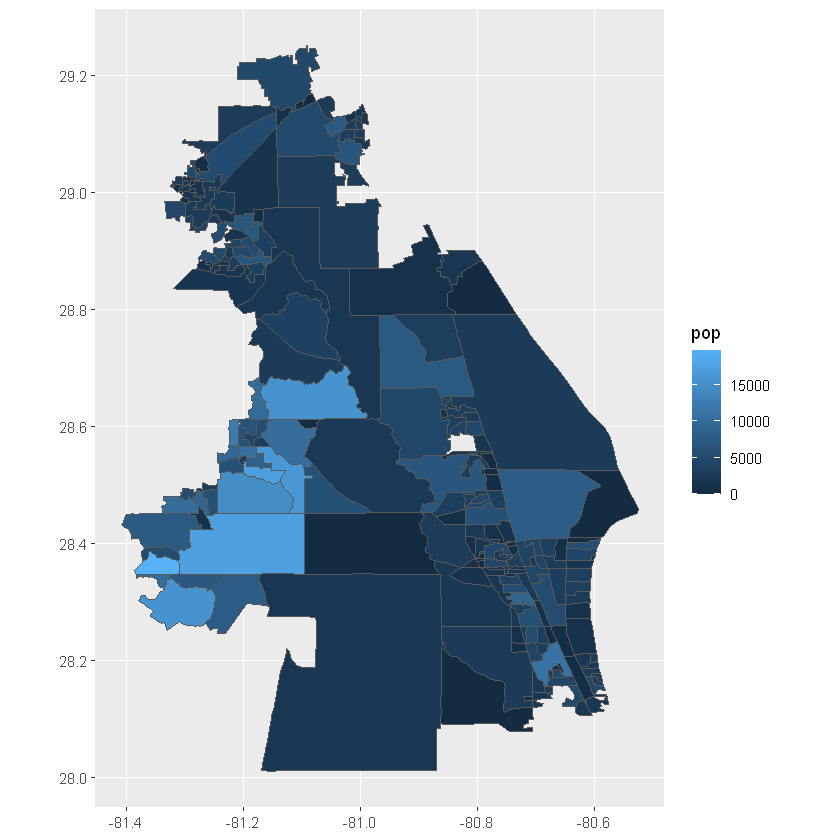

In [7]:
fl250 %>% ggplot(aes(fill = pop)) + 
    geom_sf()

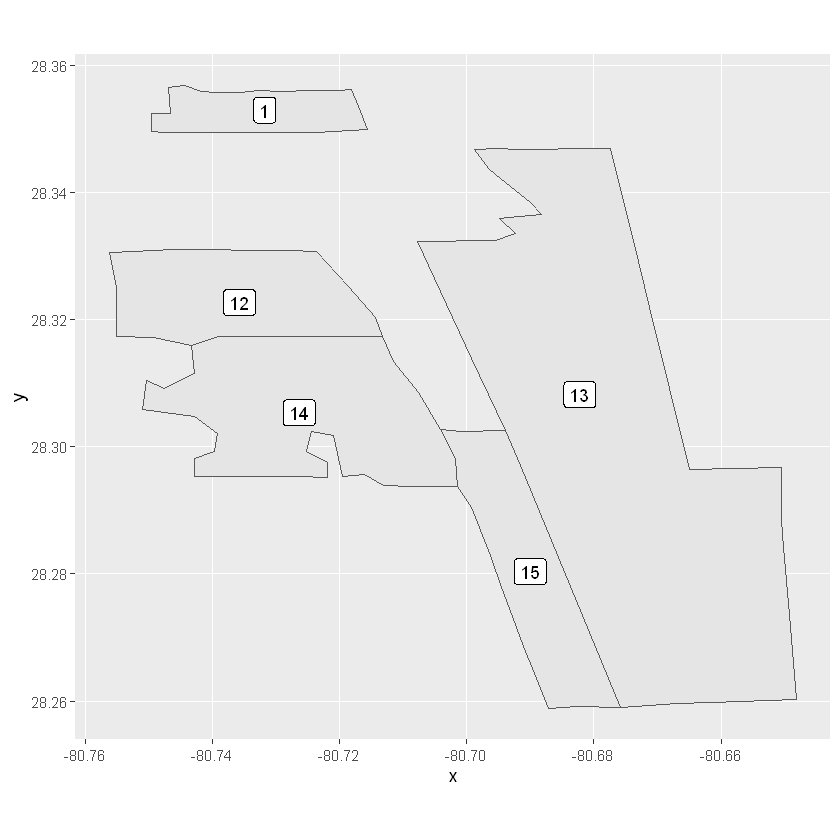

In [9]:
fl250$id <- 1:250
fl250[c(12,13,1,14,15),] %>% ggplot() +
    geom_sf() + 
geom_sf_label(aes(label = id))

In [10]:
# List of all precients each precinct is adjacent to
# (corner touching doesn't qualify)
adjlist <- poly2nb(pl = fl250, queen = FALSE)
adjlist[[25]]

[1] 17 20

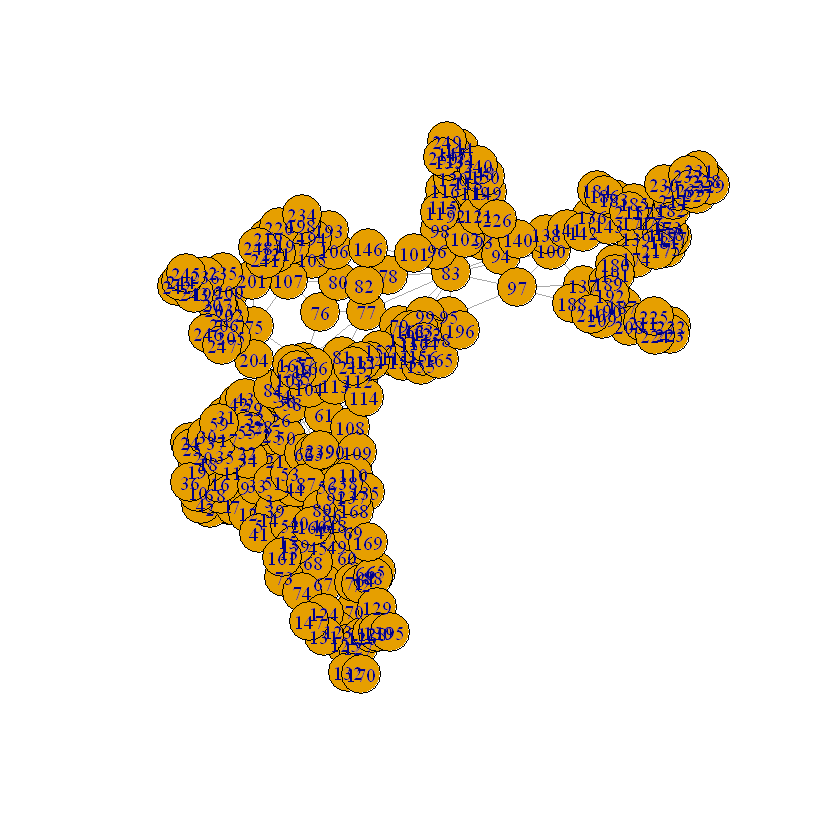

In [11]:
plot(graph_from_adj_list(adjlist, mode = 'total'))

In [12]:
# Zero-index the labels so that the C++ back end is happy
for(i in 1:250) {
    adjlist[[i]] <- adjlist[[i]]-1
}
adjlist[[25]]

[1] 16 19

Redistricting with MCMC

In [13]:
alg_mcmc <- redist.mcmc(adjobj = algdat.pfull$adjlist, # adjacency list
                        popvec = algdat.pfull$precinct.data$pop, 
                        ndists = 3,
                        nsims = 10000,
                        savename = "redist.mcmc")


redist.mcmc(): Automated Redistricting Simulation Using
         Markov Chain Monte Carlo

Preprocessing data.


Using redist.rsg() to generate starting values.

10 percent done.
Metropolis acceptance ratio: 0.968969

20 percent done.
Metropolis acceptance ratio: 0.969985

30 percent done.
Metropolis acceptance ratio: 0.967322

40 percent done.
Metropolis acceptance ratio: 0.965741

50 percent done.
Metropolis acceptance ratio: 0.964193

60 percent done.
Metropolis acceptance ratio: 0.965494

70 percent done.
Metropolis acceptance ratio: 0.966281

80 percent done.
Metropolis acceptance ratio: 0.966746

90 percent done.
Metropolis acceptance ratio: 0.966441

100 percent done.
Metropolis acceptance ratio: 0.965897



In [14]:
initcds <- algdat.pfull$cdmat[,1]
alg_mcmc <- redist.mcmc(adjobj = algdat.pfull$adjlist,
                        popvec = algdat.pfull$precinct.data$pop,
                        initcds = initcds,
                        nsims = 10000,
                        savename = "redist.mcmc")


redist.mcmc(): Automated Redistricting Simulation Using
         Markov Chain Monte Carlo

Preprocessing data.

10 percent done.
Metropolis acceptance ratio: 0.95996

20 percent done.
Metropolis acceptance ratio: 0.95948

30 percent done.
Metropolis acceptance ratio: 0.959987

40 percent done.
Metropolis acceptance ratio: 0.95849

50 percent done.
Metropolis acceptance ratio: 0.957992

60 percent done.
Metropolis acceptance ratio: 0.96016

70 percent done.
Metropolis acceptance ratio: 0.960852

80 percent done.
Metropolis acceptance ratio: 0.96137

90 percent done.
Metropolis acceptance ratio: 0.962329

100 percent done.
Metropolis acceptance ratio: 0.962196



In [15]:
class(alg_mcmc)
names(alg_mcmc)

[1] "redist"

[1] "partitions"             "distance_parity"        "distance_original"     
 [4] "mhdecisions"            "mhprob"                 "pparam"                
 [7] "beta_sequence"          "energy_psi"             "constraint_pop"        
[10] "constraint_compact"     "constraint_segregation" "constraint_similar"    
[13] "constraint_countysplit" "boundary_partitions"    "boundaryratio"

Using Multiple Chains

In [16]:
RNGkind(kind = "L'Ecuyer-CMRG")
set.seed(1)
nchains <- 4
nsims <- 10000
mcmc_chains <- lapply(1:nchains, function(x){
          redist.mcmc(adjobj = algdat.pfull$adjlist, 
                      popvec = algdat.pfull$precinct.data$pop, 
                      nsims = nsims,
                      ndists = 3)
})


redist.mcmc(): Automated Redistricting Simulation Using
         Markov Chain Monte Carlo

Preprocessing data.


Using redist.rsg() to generate starting values.

10 percent done.
Metropolis acceptance ratio: 0.964965

20 percent done.
Metropolis acceptance ratio: 0.961981

30 percent done.
Metropolis acceptance ratio: 0.963988

40 percent done.
Metropolis acceptance ratio: 0.95974

50 percent done.
Metropolis acceptance ratio: 0.961392

60 percent done.
Metropolis acceptance ratio: 0.96066

70 percent done.
Metropolis acceptance ratio: 0.961566

80 percent done.
Metropolis acceptance ratio: 0.96087

90 percent done.
Metropolis acceptance ratio: 0.960662

100 percent done.
Metropolis acceptance ratio: 0.960596


redist.mcmc(): Automated Redistricting Simulation Using
         Markov Chain Monte Carlo

Preprocessing data.


Using redist.rsg() to generate starting values.

10 percent done.
Metropolis acceptance ratio: 0.955956

20 percent done.
Metropolis acceptance ratio: 0.96048

30 pe

In [17]:
seg <- redist.segcalc(algout = alg_mcmc, 
                      grouppop = algdat.pfull$precinct.data$blackpop,
                      fullpop = algdat.pfull$precinct.data$pop)


Diagnostic Plots

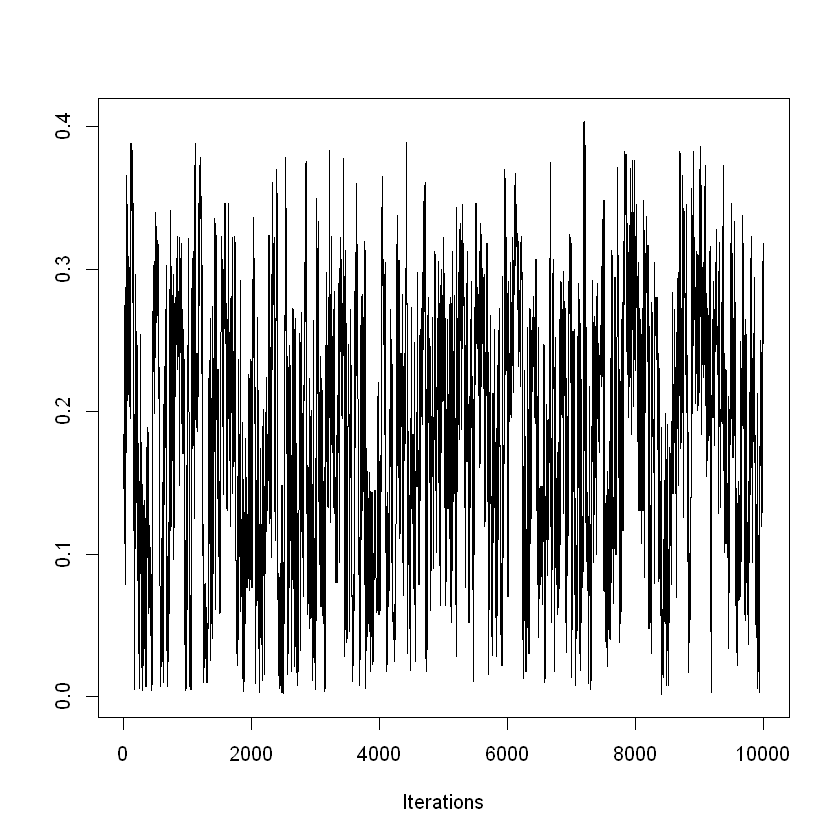

In [18]:
# Trace Plot
redist.diagplot(seg, plot = "trace")

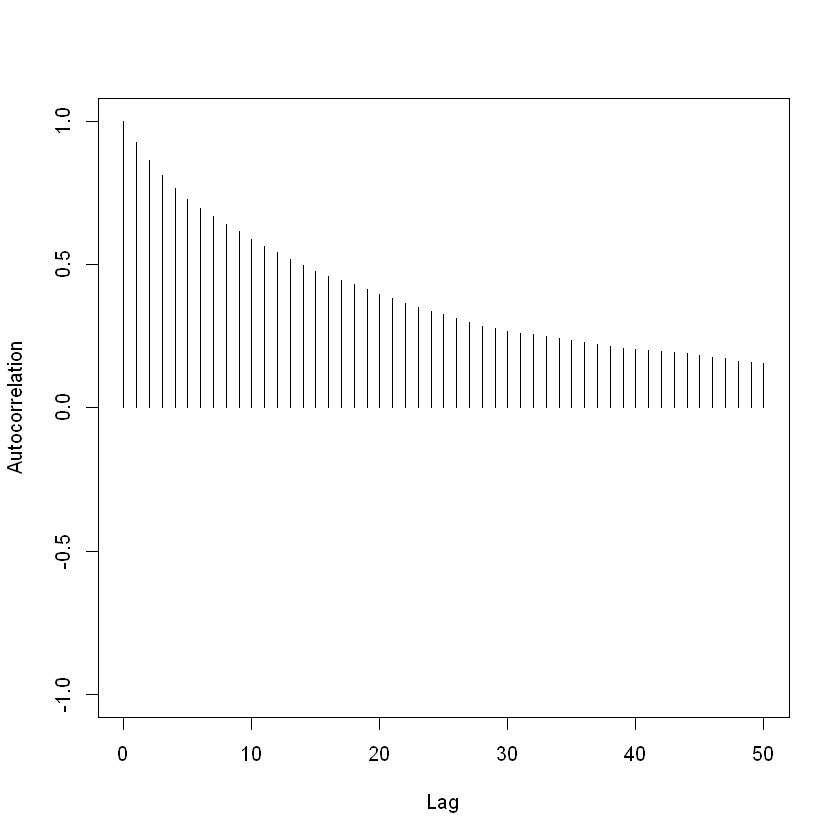

In [19]:
# Autocorrelation Plot
redist.diagplot(seg, plot = "autocorr")

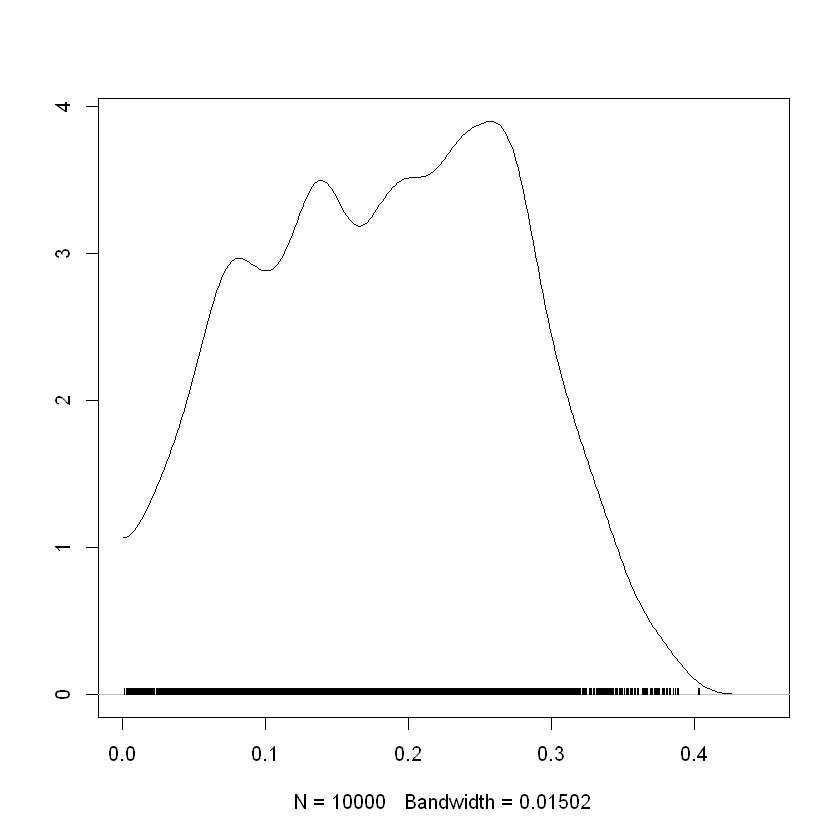

In [20]:
# Density Plot
redist.diagplot(seg, plot = "densplot")

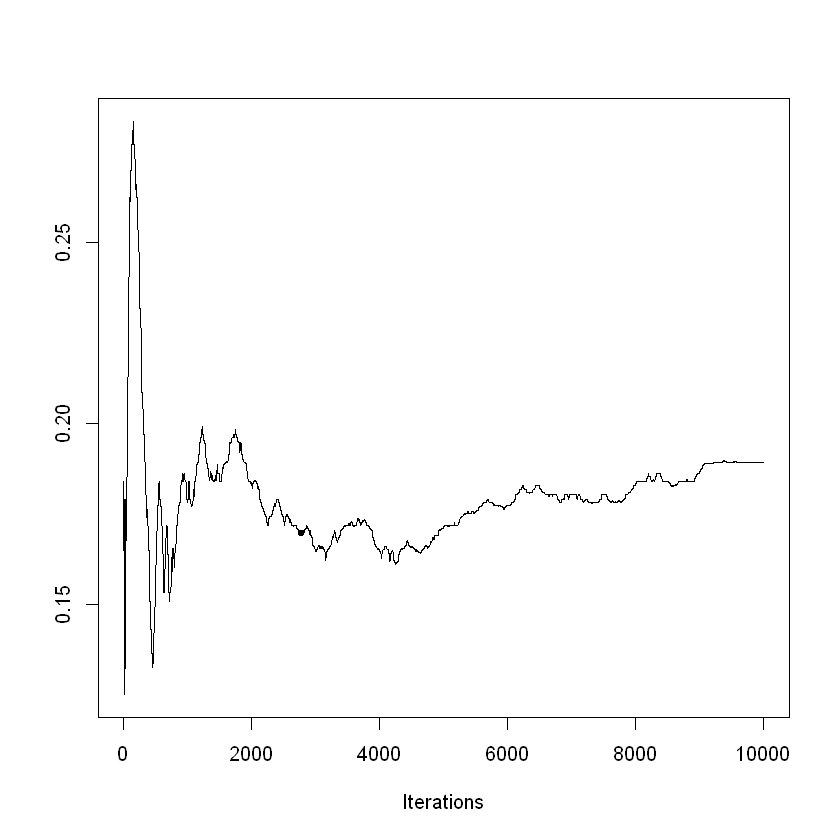

In [21]:
# Mean plot
redist.diagplot(seg, plot = "mean")